# OFIT from TT-1 calibration plane

camera calibration has not been performed in TT-1 tokamak. However, simple length to pixel ratio has been determined

conclusion: not work bro

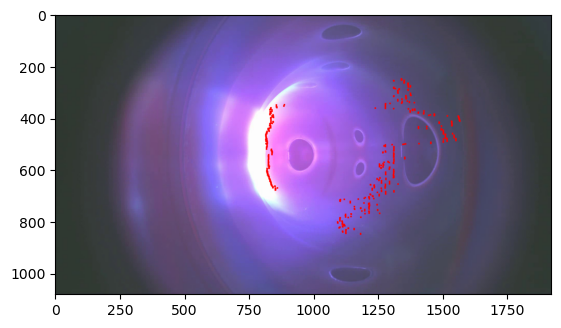

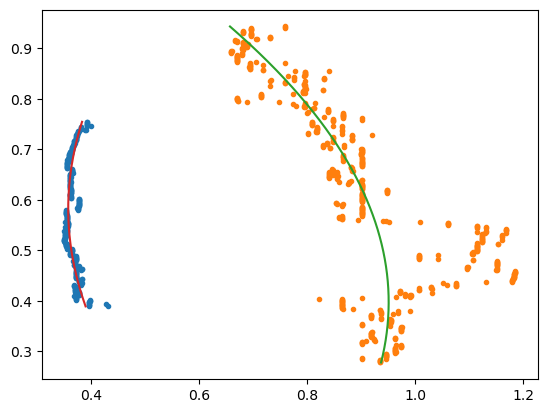

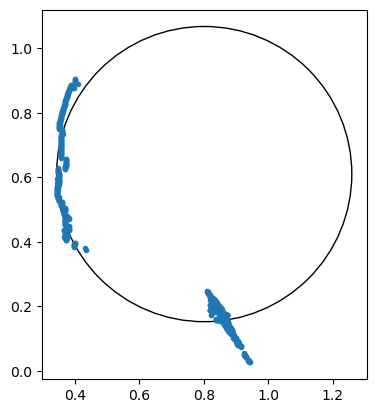

In [64]:
from OFIT_dir.OFIT import process_image, field_edge_detection
from OFIT_dir.transformation import poloidal_transformation
from OFIT_dir.transformation import TT1_camera_translation
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import os

#functions to calculate parameters of circle
def circle_eqn(params, x,y):
    xc,yc,r = params
    return (x-xc)**2 + (y-yc)**2 - r**2

def x_pix_to_plane(x,pixel_to_physical_ratio = 1/0.9,plane_edge_pixel = 500):
    """
    funciton to convert pixel coordinate to projection plane using ratio
    """

    return (x - plane_edge_pixel)*pixel_to_physical_ratio / 1000

def y_pix_to_plane(y,pixel_to_physical_ratio=1/0.9,plane_edge_pixel = 0):

    return (y-plane_edge_pixel)*pixel_to_physical_ratio / 1000

retreive_shot_path = lambda shot_no: os.path.join(r"resources\TTI frame", f"{shot_no}\\{shot_no}_frames_jpg")

shot_path = retreive_shot_path(966)
all_frames = os.listdir(shot_path)

for frame_file in all_frames:

    #retreive image file
    frame_path = os.path.join(shot_path,frame_file)
    img = plt.imread(frame_path)

    img_mean_brightness = np.mean(img)
    if img_mean_brightness < 100 or img_mean_brightness > 130:
        continue

    #process input image
    img_process = process_image(img)

    #edge detection
    (x_high,y_high), (x_low, y_low) = field_edge_detection(img_process)

    #convert to calibration plane
    u_high, v_high = x_pix_to_plane(x_high), y_pix_to_plane(y_high)
    u_low, v_low = x_pix_to_plane(x_low), y_pix_to_plane(y_low)

    R_high, Z_high,high_param, *_ = poloidal_transformation(u_high, v_high,camera_location=TT1_camera_translation,
                            RANSAC_sample_size=3,RANSAC_n=30,RANSAC_epsilon=0.005)
    
    R_low, Z_low, low_parm,*_ = poloidal_transformation(u_low, v_low,camera_location=TT1_camera_translation,
                            RANSAC_sample_size=3,RANSAC_n=30,RANSAC_epsilon=0.005)
    
    R_com, Z_com = np.append(R_high,R_low), np.append(Z_high, Z_low)

    (R0,Z0,r), *_ = optimize.leastsq(circle_eqn,args =(R_com,Z_com),x0=[0.65,0,0.05])

    break

horizontal_parabola_function = lambda y,a,b,c: a*y**2 + b*y + c

def overlay_img(img,x,y):
    for xi, yi in zip(x,y):
        img[yi-3:yi+3, xi-3:xi+3] = [255,0,0]

img_copy = img.copy()
overlay_img(img_copy,x_high,y_high)
overlay_img(img_copy,x_low,y_low)

plt.imshow(img_copy)
plt.show()

v_range_low = np.linspace(min(v_low),max(v_low), 1000)
v_range_high = np.linspace(min(v_high),max(v_high), 1000)

plt.plot(u_high,v_high,".")
plt.plot(u_low,v_low,".")
plt.plot(horizontal_parabola_function(v_range_low,*low_parm),v_range_low)
plt.plot(horizontal_parabola_function(v_range_high,*high_param),v_range_high)
plt.show()

plt.plot(R_com,Z_com,".")
circle = Circle((R0,Z0),r, fill = False)
plt.gca().set_aspect("equal")
plt.gca().add_patch(circle)